In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install mne autoreject numpy scikit-learn imbalanced-learn matplotlib

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from mne import create_info, EpochsArray
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [ ]:
root = "data/EEG/MI_EEG_20250325_195036.csv"
SAMPLE_RATE = 250

# Event markers from the original data-collection script
MARKER_RIGHT = "1.0"  # Right hand imagery start
MARKER_LEFT = "2.0"   # Left hand imagery start
MARKER_STOP = "3.0"   # End of imagery period

# Epoching parameters (in seconds)
# Include 1 second before the start marker for baseline
EPOCH_START = -1.0  # Start 1 second before the marker
EPOCH_END = 3.0    # End 4 seconds after the marker

# Define baseline period for normalization
BASELINE_START = -1.0  # Start of baseline period
BASELINE_END = 0.0    # End of baseline period (stimulus onset)

CHANNELS = ["CH1","CH2","CH3","CH4","CH5","CH6","CH7","CH8"]
df = pd.read_csv(root)

for ch in ["CH1","CH2","CH3","CH4","CH5","CH6","CH7","CH8"]:
    df[ch] = pd.to_numeric(df[ch], errors='coerce')
df["lsl_timestamp"] = pd.to_numeric(df["lsl_timestamp"], errors='coerce')

df.dropna(subset=["lsl_timestamp","CH1","CH2","CH3","CH4","CH5","CH6","CH7","CH8"], inplace=True)
df.reset_index(drop=True, inplace=True)

timestamps = df["lsl_timestamp"].values - df["lsl_timestamp"].values[0]
# The file columns are:
# ['lsl_timestamp','CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8','marker']

# Extract time from 'lsl_timestamp'.
# We'll re-base it so that time starts at 0 for convenience.
time_raw = df['lsl_timestamp'].values
time = time_raw - time_raw[0]

# Extract 8 EEG channels into a NumPy array of shape (n_channels, n_samples).
channel_cols = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8']
data = df[channel_cols].values  # shape: (8, n_samples)

# Rereference to the grand average
grand_avg = np.mean(data, axis=1, keepdims=True)
data = data - grand_avg

# The 'marker' column may or may not contain events.
markers = df['marker'].values

# We do not know the exact sampling rate from the file,
# so set it if you know it (e.g., 250 Hz). Adjust as needed.
fs = 250.0

print("Data shape:", data.shape)
print("Channels:", channel_cols)
print("Duration (s):", time[-1], "seconds (approx).")

Data shape: (109140, 8)
Channels: ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']
Duration (s): 436.15579895756673 seconds (approx).


Create a function to filter the data

In [ ]:
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    """
    Apply a zero-phase Butterworth bandpass filter to the data.
    data  : 2D array [n_samples, n_channels]
    fs    : Sample rate
    lowcut, highcut : Filter passband edges in Hz
    order : Filter order
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

Apply filtering

filtered_eeg shape: (109140, 8)
raw_eeg shape: (109140, 8)


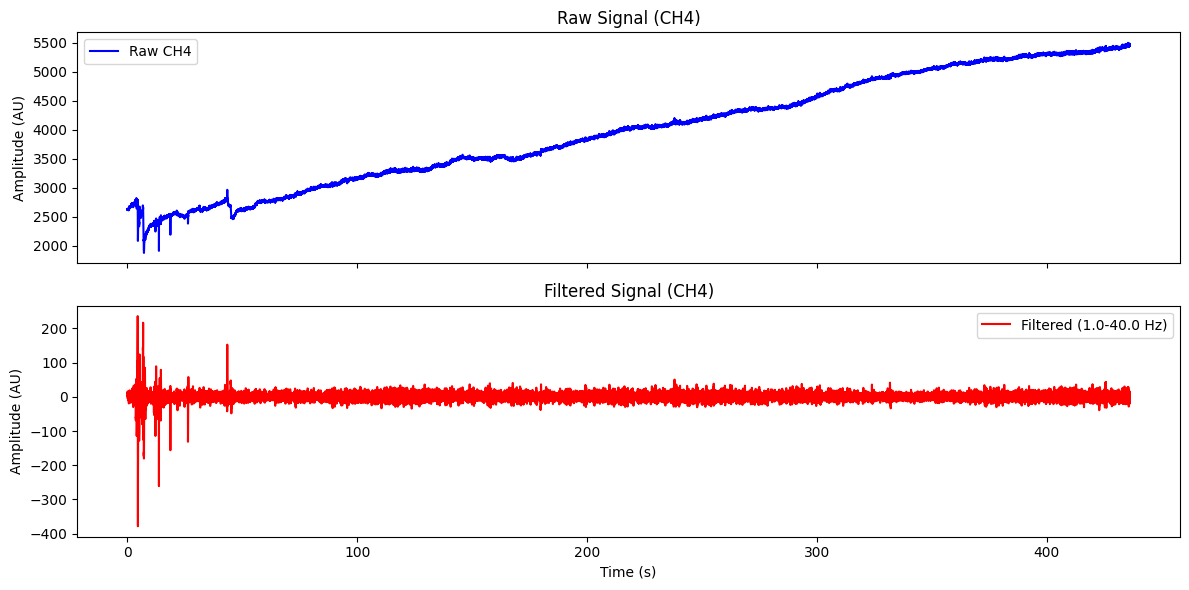

In [ ]:
LOWCUT = 1.0
HIGHCUT = 40.0
raw_eeg = data
filtered_eeg = bandpass_filter(raw_eeg, SAMPLE_RATE, LOWCUT, HIGHCUT, 4)
print("filtered_eeg shape:", filtered_eeg.shape)
print("raw_eeg shape:", raw_eeg.shape)

ch_index = 6

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# -- Raw
axes[0].plot(time, raw_eeg[:, ch_index], label='Raw CH4', color='b')
axes[0].set_title("Raw Signal (CH4)")
axes[0].set_ylabel("Amplitude (AU)")
axes[0].legend()
axes[0].autoscale(enable=True, axis='y')

# -- Filtered
axes[1].plot(time, filtered_eeg[:, ch_index], label=f'Filtered ({LOWCUT}-{HIGHCUT} Hz)', color='r')
axes[1].set_title("Filtered Signal (CH4)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude (AU)")
axes[1].legend()
axes[1].autoscale(enable=True, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
#@title Epoching
def extract_epochs(signal_data, timestamps, events, fs, t_start, t_end):
    """
    Extract epochs from continuous signal_data given event timestamps.
    Includes baseline period before the event.

    Parameters:
    -----------
    signal_data : array (n_samples, n_channels)
        The continuous EEG data
    timestamps : array (n_samples,)
        Timestamps for each sample
    events : list of tuples (timestamp, label)
        Event markers with their timestamps
    fs : float
        Sampling rate in Hz
    t_start : float
        Start time relative to event (negative for baseline)
    t_end : float
        End time relative to event
    """
    epochs_dict = {}
    epoch_len = int((t_end - t_start) * fs)
    samples_in_baseline = int(abs(t_start) * fs)  # number of samples in baseline period

    print(f"\nEpoch extraction parameters:")
    print(f"Epoch window: {t_start}s to {t_end}s")
    print(f"Baseline period: {t_start}s to 0s")
    print(f"Samples per epoch: {epoch_len}")
    print(f"Baseline samples: {samples_in_baseline}")

    for (evt_time, evt_label) in events:
        # Convert event time to sample index
        evt_sample = np.argmin(np.abs(timestamps - evt_time))

        # Calculate start and end samples
        start_sample = evt_sample + int(t_start * fs)  # Will be negative offset for baseline
        end_sample = start_sample + epoch_len

        # Verify we have enough data
        if start_sample < 0:
            print(f"Warning: Skipping epoch at {evt_time:.2f}s - insufficient baseline data")
            continue
        if end_sample >= len(signal_data):
            print(f"Warning: Skipping epoch at {evt_time:.2f}s - reaches beyond end of recording")
            continue

        # Extract epoch including baseline
        epoch_data = signal_data[start_sample:end_sample, :]

        # Verify baseline period
        baseline_end_idx = samples_in_baseline
        baseline = epoch_data[:baseline_end_idx, :]
        if len(baseline) != samples_in_baseline:
            print(f"Warning: Incorrect baseline length at {evt_time:.2f}s")
            continue

        # Store in dictionary by condition
        if evt_label not in epochs_dict:
            epochs_dict[evt_label] = []
        epochs_dict[evt_label].append(epoch_data)

    # Convert list of epochs to numpy arrays
    for label in epochs_dict:
        epochs_dict[label] = np.array(epochs_dict[label])
        print(f"\nCondition: {label}")
        print(f"Number of epochs: {len(epochs_dict[label])}")
        print(f"Epoch shape: {epochs_dict[label].shape}")

        # Verify first epoch timing
        n_baseline_samples = int(abs(t_start) * fs)
        print(f"Baseline samples in each epoch: {n_baseline_samples}")

    return epochs_dict

events = []
for i, marker_val in enumerate(df["marker"]):
    if str(marker_val) == MARKER_RIGHT:
        events.append((timestamps[i], "Right"))
    elif str(marker_val) == MARKER_LEFT:
        events.append((timestamps[i], "Left"))

epochs_dict = extract_epochs(filtered_eeg, timestamps, events,
                              fs=SAMPLE_RATE,
                              t_start=EPOCH_START,
                              t_end=EPOCH_END)


Epoch extraction parameters:
Epoch window: -1.0s to 3.0s
Baseline period: -1.0s to 0s
Samples per epoch: 1000
Baseline samples: 250

Condition: Left
Number of epochs: 17
Epoch shape: (17, 1000, 8)
Baseline samples in each epoch: 250

Condition: Right
Number of epochs: 19
Epoch shape: (19, 1000, 8)
Baseline samples in each epoch: 250


Fourier Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram

def compute_fft_and_plot_spectrogram(epoch_data, fs, channel=0):
    """
    Compute the Fourier transform and plot the spectrogram for a single channel in a single epoch.

    Parameters
    ----------
    epoch_data : np.ndarray
        2D array of shape (n_channels, n_samples) representing a single epoch of EEG data.
    fs : float
        Sampling rate (Hz).
    channel : int
        Index of the channel to process (default=0).
    """
    # Extract the time-series for the desired channel
    signal = epoch_data[:, channel]  # shape: (n_samples,)

    # --- 1) Compute the FFT ---
    n_samples = signal.shape[0]
    xf = fftfreq(n_samples, 1/fs)           # Frequency axis
    yf = fft(signal)                        # Complex FFT result
    fft_magnitude = np.abs(yf)             # Magnitude spectrum

    # --- 2) Plot the FFT (Magnitude Spectrum) ---
    # (Optional but included for clarity)
    plt.figure()
    plt.plot(xf[:n_samples // 2], fft_magnitude[:n_samples // 2])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title(f"FFT - Epoch (ch={channel})")
    plt.show()

    # --- 3) Compute and Plot Spectrogram ---
    f_spec, t_spec, Sxx = spectrogram(signal, fs=fs, nperseg=128, noverlap=64)
    # Convert power to decibels to improve visualization
    Sxx_dB = 10 * np.log10(Sxx + 1e-16)

    plt.figure()
    plt.pcolormesh(t_spec, f_spec, Sxx_dB, shading='gouraud')
    plt.colorbar(label='Power (dB)')
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title(f"Spectrogram - Epoch (ch={channel})")
    plt.show()

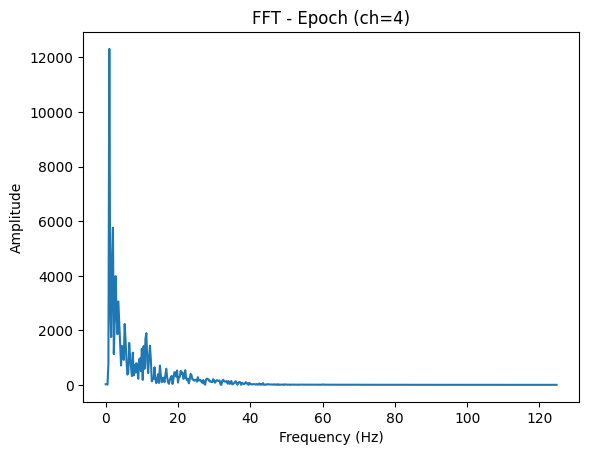

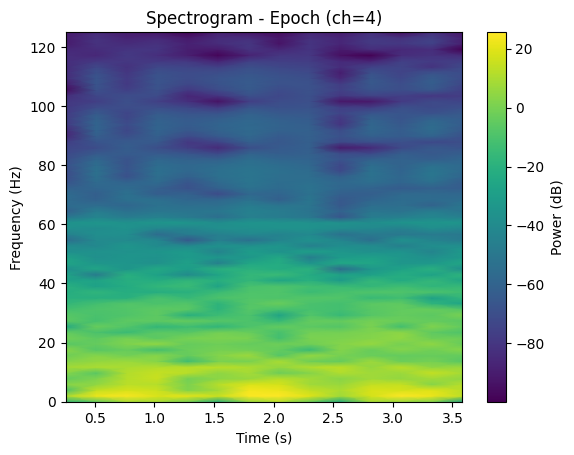

In [ ]:
epoch_idx = 1
channel_idx = 4

# Grab the single epoch from your data
# shape: (n_channels, n_samples)
epoch_data = epochs_dict['Left'][epoch_idx]

# Then call our function
compute_fft_and_plot_spectrogram(epoch_data, fs, channel=channel_idx)

Function to compute band power for each condition

In [ ]:
def bandpower_boxplot(signal, fs, condition_name, channel_name):
    """
    Computes the bandpower of the given 1D signal in the mu and beta frequency bands,
    normalized relative to the baseline period.

    Parameters:
    -----------
    signal : array-like
        The EEG signal data
    fs : float
        Sampling rate in Hz
    condition_name : str
        Name of the condition (e.g., "Right" or "Left")
    channel_name : str
        Name of the channel (e.g., "CH2")
    """
    # Define frequency bands
    mu_band = (8, 13)  # Hz
    beta_band = (13, 30)  # Hz

    # Extract baseline period (first second of data)
    baseline_samples = int(abs(EPOCH_START) * fs)
    baseline_signal = signal[:baseline_samples]
    task_signal = signal[baseline_samples:]

    # Compute power spectral density using Welch's method for both periods
    from scipy.signal import welch

    # Use the same nperseg for both periods to ensure consistent frequency arrays
    nperseg = min(len(baseline_signal), len(task_signal))
    f, Pxx_baseline = welch(baseline_signal, fs=fs, nperseg=nperseg)
    f, Pxx_task = welch(task_signal, fs=fs, nperseg=nperseg)

    # Calculate power in each band for both periods
    mu_mask = (f >= mu_band[0]) & (f <= mu_band[1])
    beta_mask = (f >= beta_band[0]) & (f <= beta_band[1])

    # Calculate baseline power
    mu_power_baseline = np.mean(Pxx_baseline[mu_mask])
    beta_power_baseline = np.mean(Pxx_baseline[beta_mask])

    # Calculate task power
    mu_power_task = np.mean(Pxx_task[mu_mask])
    beta_power_task = np.mean(Pxx_task[beta_mask])

    # Normalize to percent change from baseline
    mu_power_norm = ((mu_power_task - mu_power_baseline) / mu_power_baseline) * 100
    beta_power_norm = ((beta_power_task - beta_power_baseline) / beta_power_baseline) * 100

    return mu_power_norm, beta_power_norm

Function for creating box plots to clearly visualize results

In [ ]:
def plot_bandpower_boxplots(epochs_dict):
    """
    Creates boxplots showing the normalized power in mu and beta frequency bands for each condition.
    Uses CH3 for left side and CH6 for right side analysis.

    Parameters:
    -----------
    epochs_dict : dict
        Dictionary containing epochs for each condition
    """
    # Initialize lists to store power values
    mu_powers = []
    beta_powers = []
    labels = []

    # Process each condition
    for condition in ["Right", "Left"]:
        if condition not in epochs_dict:
            continue

        epochs = epochs_dict[condition]

        # Process each epoch
        for epoch in epochs:
            # Get contralateral and ipsilateral channels
            if condition == "Right":
                contra_ch = 2  # CH3 (Left hemisphere)
                ipsi_ch = 5    # CH6 (Right hemisphere)
            else:
                contra_ch = 5  # CH6 (Right hemisphere)
                ipsi_ch = 2    # CH3 (Left hemisphere)

            # Calculate power for contralateral hemisphere
            mu_power_contra, beta_power_contra = bandpower_boxplot(
                epoch[:, contra_ch], SAMPLE_RATE, condition, f"Contra_{condition}"
            )
            mu_powers.append(mu_power_contra)
            beta_powers.append(beta_power_contra)
            labels.append(f"{condition} Contra")

            # Calculate power for ipsilateral hemisphere
            mu_power_ipsi, beta_power_ipsi = bandpower_boxplot(
                epoch[:, ipsi_ch], SAMPLE_RATE, condition, f"Ipsi_{condition}"
            )
            mu_powers.append(mu_power_ipsi)
            beta_powers.append(beta_power_ipsi)
            labels.append(f"{condition} Ipsi")
        # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot mu band power
    data_mu = [mu_powers[i::4] for i in range(4)]  # Group by condition and hemisphere
    ax1.boxplot(data_mu, labels=["Right Contra (CH6)", "Right Ipsi (CH3)", "Left Contra (CH3)", "Left Ipsi (CH6)"])
    ax1.set_title("μ Band Power (8-13 Hz)")
    ax1.set_ylabel("Power Change from Baseline (%)")
    ax1.grid(True, alpha=0.3)

    # Add horizontal line at zero
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.2)

    # Plot beta band power
    data_beta = [beta_powers[i::4] for i in range(4)]  # Group by condition and hemisphere
    ax2.boxplot(data_beta, labels=["Right Contra (CH6)", "Right Ipsi (CH3)", "Left Contra (CH3)", "Left Ipsi (CH6)"])
    ax2.set_title("β Band Power (13-30 Hz)")
    ax2.set_ylabel("Power Change from Baseline (%)")
    ax2.grid(True, alpha=0.3)

    # Add horizontal line at zero
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.2)

    plt.tight_layout()
    plt.show()

<ipython-input-13-fa697c9e46d9>:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_mu, labels=["Right Contra (CH6)", "Right Ipsi (CH3)", "Left Contra (CH3)", "Left Ipsi (CH6)"])
<ipython-input-13-fa697c9e46d9>:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_beta, labels=["Right Contra (CH6)", "Right Ipsi (CH3)", "Left Contra (CH3)", "Left Ipsi (CH6)"])


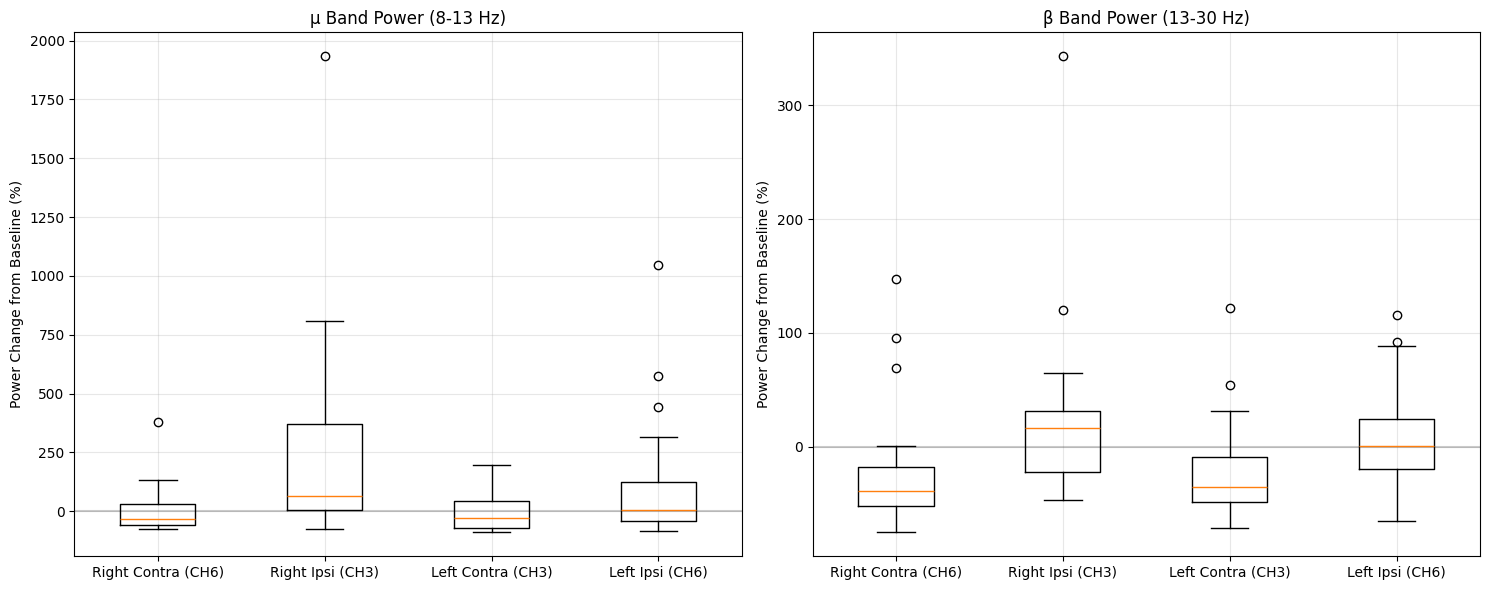

In [ ]:
plot_bandpower_boxplots(epochs_dict)